In [2]:
from pathlib import Path
from carps.analysis.gather_data import read_jsonl_content
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn
from omegaconf import OmegaConf
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from tqdm import tqdm

setup_seaborn()

log_fn = "DACBOEnvActions.jsonl"
rundirs = [
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed1/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed2/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed3/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed4/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed5/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed1/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed2/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed3/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed4/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed5/BBOB/*",
    # "../runs_eval_icml/PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SMAC3-BlackBoxFacade_Ibbob2d_3seeds--seed3/*"
    # "../runs_eval_icml/PPO-RNN--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-DefaultAction_Ibbob2d_fid8_3seeds*",
    # "../runs_eval_icml/PPO-RNN--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_3seeds*",
    "../runs_eval_icml/PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds*",
    "../runs_eval/SAWEI-P/*",
]
filenames = []
while rundirs:
    rundir = rundirs.pop()
    print("gather from", rundir)
    if "*" in str(rundir):
        parent_dir = Path(rundir).parent
        _rundirs = list(parent_dir.glob(Path(rundir).name))
        rundirs.extend(_rundirs)
        print(rundirs)
    _fns = list(Path(rundir).glob(f"**/{log_fn}"))
    filenames.extend(_fns)

def load_actions(filenames: list[str], add_obs: bool = False) -> pd.DataFrame:
    actions = []
    for rundir in tqdm(filenames):
        rundir = Path(rundir)
        cfg_fn = rundir.parent / ".hydra/config.yaml"
        cfg = OmegaConf.load(cfg_fn)
        acts = read_jsonl_content(rundir)
        if "action_values" in acts:
            acts["action"] = acts["action_values"].map(lambda x: x[1])
        policy_id = cfg.policy_id if hasattr(cfg, "policy_id") else rundir.parts[-8]
        acts["policy_id"] = policy_id
        acts = add_metadata_to_dict(acts, cfg)
        if "config" in acts:
            del acts["config"]

        if add_obs:
            obs = read_jsonl_content(rundir.parent / "DACBOEnvLogs.jsonl")
            obs_keys = list(obs.iloc[0]["observation"].keys())

            expanded = obs["observation"].apply(pd.Series)
            expanded.columns = obs_keys
            obs = obs.drop(columns="observation").join(expanded)
            acts = acts.merge(
                obs,
                on="n_trials",
                how="left",
                # validate="many_to_one"
            )

        actions.append(acts)
    actions = pd.concat(actions).reset_index(drop=True)
    return actions

print(len(filenames))
print(filenames[-1])
actions = load_actions(filenames, add_obs=True)
actions.to_parquet("actions.parquet")

# takes 3min

gather from ../runs_eval/SAWEI-P/*
['../runs_eval_icml/PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds*', PosixPath('../runs_eval/SAWEI-P/BNNBO'), PosixPath('../runs_eval/SAWEI-P/OptBench'), PosixPath('../runs_eval/SAWEI-P/BBOB'), PosixPath('../runs_eval/SAWEI-P/YAHPO')]
gather from ../runs_eval/SAWEI-P/YAHPO
gather from ../runs_eval/SAWEI-P/BBOB
gather from ../runs_eval/SAWEI-P/OptBench
gather from ../runs_eval/SAWEI-P/BNNBO
gather from ../runs_eval_icml/PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds*
[PosixPath('../runs_eval_icml/PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed5'), PosixPath('../runs_eval_icml/PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed2'), PosixPath('../runs_eval_icml/PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed3'), PosixPath('../runs_eval_icml/

100%|██████████| 4800/4800 [12:34<00:00,  6.36it/s]


In [11]:
actions.columns


Index(['action', 'action_type', 'n_trials', 'policy_id', 'seed', 'task_id',
       'optimizer_id', 'reward_id', 'action_space_id', 'observation_space_id',
       'objective_function', 'reward', 'ubr_smoothed_gradient', 'acq_value_PI',
       'acq_value_WEI_explore', 'previous_param'],
      dtype='object')

In [1]:
from pathlib import Path
from carps.analysis.gather_data import read_jsonl_content
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn
from omegaconf import OmegaConf
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from tqdm import tqdm

%matplotlib inline
setup_seaborn()

actions = pd.read_parquet("actions.parquet")
# actions["policy_id"] = actions["policy_id"].map(lambda x: "PPO-fid8" if "fid8" in x else x)
# actions["policy_id"] = actions["policy_id"].map(lambda x: "PPO-24" if "AlphaNet" in x else x)

# for task_id, gdf in actions.groupby("task_id"):
#     ax = sns.lineplot(data=gdf, x="n_trials", y="action", hue="policy_id")
#     ax.set_title(task_id)
#     plt.show()
#     break


In [20]:
from carps.analysis.gather_data import normalize

def get_benchmark_id(task_id: str) -> str:
    if task_id.startswith("bbob/2"):
        return "BBOB-2d"
    if task_id.startswith("bbob/8"):
        return "BBOB-8d"
    if task_id.startswith("yahpo"):
        return "YAHPO"
    if task_id.startswith("bnnbo"):
        return "nasengb"
    else:
        return "OptBench"
    raise ValueError(f"unkown task {task_id}")

def filter_experiments(logs: pd.DataFrame, key: str = "optimizer_id") -> pd.DataFrame:
    logs =  logs[
        ((logs[key].str.startswith("PPO-AlphaNet--")) \
        | (logs[key].str.startswith("Default")) \
        | (logs[key].str.startswith("SAWEI")) \
        | (logs[key].str.startswith("SMAC-AC--")) \
        | (logs[key].str.startswith("PPO-24")) \
        | (logs[key].str.startswith("PPO-fid8")) \
        | (logs[key].str.startswith("SMAC-AC--24")) \
        | (logs[key].str.startswith("SMAC-AC--fid8"))) \

        & (~logs[key].str.contains("Ssmart"))
    ].copy().reset_index()
    logs[key] = logs[key].map(lambda x: x.replace("-AlphaNet",""))
    logs[key] = logs[key].map(lambda x: x.replace("-AC",""))
    logs[key] = logs[key].map(lambda x: x.replace("eplenI","eplen | "))
    logs[key] = logs[key].map(lambda x: x.replace("symlogregretI","symlogregret | "))
    return logs

def reduce_opt_id(optimizer_id: str) -> str:
    prefixes = [
        "PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret",
        "PPO-AlphaNet2--dacbo_Cepisode_length_scaled_plus_logregret",
        "PPO-AlphaNet3--dacbo_Cepisode_length_scaled_plus_logregret",
        "PPO-AlphaNet--dacbo_Csymlogregret",
        "PPO-AlphaNet2--dacbo_Csymlogregret",
        "PPO-AlphaNet3--dacbo_Csymlogregret",
        "SMAC-AC--dacbo_Cepisode_length_scaled_plus_logregret",
        "SMAC-AC--dacbo_Csymlogregret",
    ]
    for prefix in prefixes:
        if optimizer_id.startswith(prefix):
            if "fid8" in optimizer_id:
                optimizer_id = f"{prefix}Ifid8"
            elif "bbob2d" in optimizer_id:
                optimizer_id = f"{prefix}Ibbob_2d"
            else:
                print(f"Sth is weird for {optimizer_id}")
            break
    optimizer_id = optimizer_id.replace(
        "dacbo_Cepisode_length_scaled_plus_logregret", "eplen").replace(
            "dacbo_Csymlogregret", "symlogregret"
        )
    return optimizer_id

actions = pd.read_parquet("actions.parquet")
print(actions["policy_id"].unique())
actions["n_trials_norm"] = actions.groupby("task_id")["n_trials"].transform(normalize)
actions["benchmark_id"] = actions["task_id"].map(get_benchmark_id)
# actions["policy_id"] = actions["policy_id"].map(reduce_opt_id)
actions = filter_experiments(actions, key="policy_id")
print(actions["policy_id"].unique())

['PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed5'
 'PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed4'
 'PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed3'
 'PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed2'
 'PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SAWEI-P_Ibbob2d_fid8_3seeds--seed1'
 'PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed5'
 'PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed4'
 'PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds--seed3'
 

['SAWEI' 'PPO-Ros--seed4' 'PPO-Ros--seed1' 'PPO-Ros--seed3'
 'PPO-Ros--seed2' 'PPO-Ros--seed5']
['YAHPO' 'BBOB-2d' 'BBOB-8d' None]


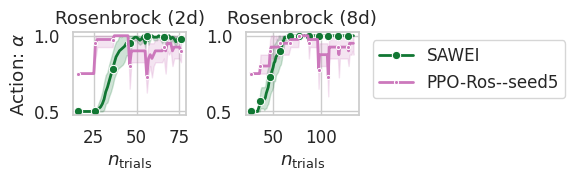

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn, get_color_palette, get_marker_palette, savefig
from carps.analysis.gather_data import get_interpolated_performance_df, normalize
import pandas as pd

def fix_benchmark_id(logs: pd.DataFrame) -> pd.DataFrame:
    def _fix_benchmark_id(row: pd.Series) -> str:
        if row["task_id"].startswith("bbob/2"):
            return "BBOB-2d"
        if row["task_id"].startswith("bbob/8"):
            return "BBOB-8d"
        if row["task_id"].startswith("yahpo"):
            return "YAHPO"
        return row["benchmark_id"]
    logs["benchmark_id"] = None
    logs["benchmark_id"] = logs.apply(_fix_benchmark_id, axis="columns")
    print(logs["benchmark_id"].unique())
    return logs

def postprocess_actions(df: pd.DataFrame) -> pd.DataFrame:
    df["optimizer_id"] = df["optimizer_id"].map(lambda x: "PPO-Ros--" + x.split("--")[-1] if "fid8" in x else x)
    df["optimizer_id"] = df["optimizer_id"].map(lambda x: "PPO-BBOB--" + x.split("--")[-1] if "bbob2d_3s" in x else x)
    df.loc[df["optimizer_id"] == "SAWEI-P", "optimizer_id"] = "SAWEI"
    df.loc[df["optimizer_id"] == "DefaultPolicy", "optimizer_id"] = "Static"
    print(df["optimizer_id"].unique())
    df = fix_benchmark_id(df)
    df["n_trials_norm"] = df.groupby("task_id")["n_trials"].transform(normalize)
    return df

palette = {
    'Static': '#88CCEE',
    'SAWEI': '#117733',
    'Random': '#44AA99',
    'PPO-Ros--mean': '#882255',
    'PPO-Ros--seed1': (0.00392156862745098,
    0.45098039215686275,
    0.6980392156862745),
    'PPO-Ros--seed2': (0.8705882352941177,
    0.5607843137254902,
    0.0196078431372549),
    'PPO-Ros--seed3': (0.00784313725490196,
    0.6196078431372549,
    0.45098039215686275),
    'PPO-Ros--seed4': (0.8352941176470589, 0.3686274509803922, 0.0),
    'PPO-Ros--seed5': (0.8, 0.47058823529411764, 0.7372549019607844),
    'PPO-Ros--vbs': '#CC6677',
    'MetaBO-Ros': '#999933',
    'MetaBO-BBOB': '#DDCC77'
}

setup_seaborn(font_scale=1.1)
%matplotlib inline

opt_ids = [
    "SAWEI",
    "PPO-Ros--seed5"
]

actions = pd.read_parquet("actions.parquet")
actions = postprocess_actions(actions)
actions = actions[actions["optimizer_id"].isin(opt_ids)]

policies = list(actions["optimizer_id"].unique())
# palette = get_color_palette(optimizers=policies)
# palette["DefaultPolicy"] = "black"
marker_palette = get_marker_palette(optimizers=policies)
titles = {
    "bbob/2/8/0": "Rosenbrock (2d)",
    "bbob/8/8/0": "Rosenbrock (8d)",
}
actions_to_plot = actions[actions["task_id"].isin(list(titles.keys()))]

fig = plt.figure(figsize=(6,2))
axes = fig.subplots(nrows=1, ncols=len(titles.keys()))
for i, (task_id, group) in enumerate(actions_to_plot.groupby("task_id")):
    ax = axes[i]
    ax = sns.lineplot(
        # data=group[(group["seed"]==2) & (group["optimizer_id"].str.contains("fid8_3seeds--seed1"))],
        data=group, #group[group["optimizer_id"].str.contains("symlog")],
        x="n_trials", y="action", hue="optimizer_id", palette=palette,
        style="optimizer_id", dashes=False, markers=marker_palette, markevery=10, linewidth=2,
        # estimator=None, units="seed",
        # style="seed"
        ax=ax
        )
    ax.set_title(titles[task_id])
    ax.set_xlabel("$n_\mathrm{trials}$")
    ax.legend().remove()
    if i == 0:
        ax.set_ylabel("Action: $\\alpha$")
    else:
        ax.set_ylabel(None)
ax.legend(bbox_to_anchor=(1.05, 1))
fig.tight_layout()
savefig(fig, "figures/results_icml/alpha_rosenbrock")
plt.show()



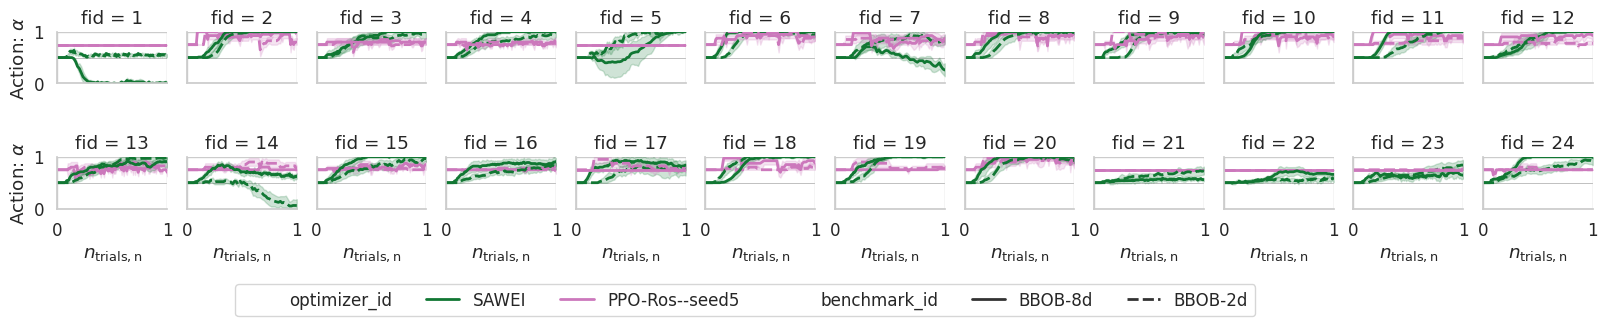

In [55]:

actions_to_plot = actions[actions["benchmark_id"].map(lambda x: x in {"BBOB-2d", "BBOB-8d"})].copy()
actions_to_plot["fid"] = actions_to_plot["task_id"].map(lambda x: int(x.split("/")[2]))
actions_to_plot["dim"] = actions_to_plot["task_id"].map(lambda x: x.split("/")[1])
actions_to_plot = actions_to_plot.sort_values(by="fid", ascending=True)

grid = sns.FacetGrid(data=actions_to_plot, col="fid", col_wrap=12, height=1.35, sharex=True)

for i, (fid, gdf) in enumerate(actions_to_plot.groupby("fid")):
    ax = grid.axes.flat[i]
    if i != 23 and False:
        continue
    ax.axhline(0.5, linestyle="-", linewidth=0.7, color="gray", zorder=0, alpha=0.5)
    ax = sns.lineplot(
        data=gdf,
        x="n_trials_norm", y="action",
        style="benchmark_id",
        hue="optimizer_id", palette=palette,
        linewidth=2,
        ax=ax
    )
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_xticks([0,1])
    # ax.set_xlabel("$n_\mathrm{trials}$")
    ax.legend().remove()
    # if i == 0:
    #     ax.set_ylabel("Action: $\\alpha$")
    # else:
    #     ax.set_ylabel(None)
ax.legend(bbox_to_anchor=(-2,-1.3), ncols=10)
grid.set_xlabels("$n_\mathrm{trials,n}$")
grid.set_ylabels("Action: $\\alpha$")
grid.figure.subplots_adjust(wspace=0.18)
# grid.figure.tight_layout()
savefig(grid.figure, "figures/results_icml/alpha_bbob")
plt.show()

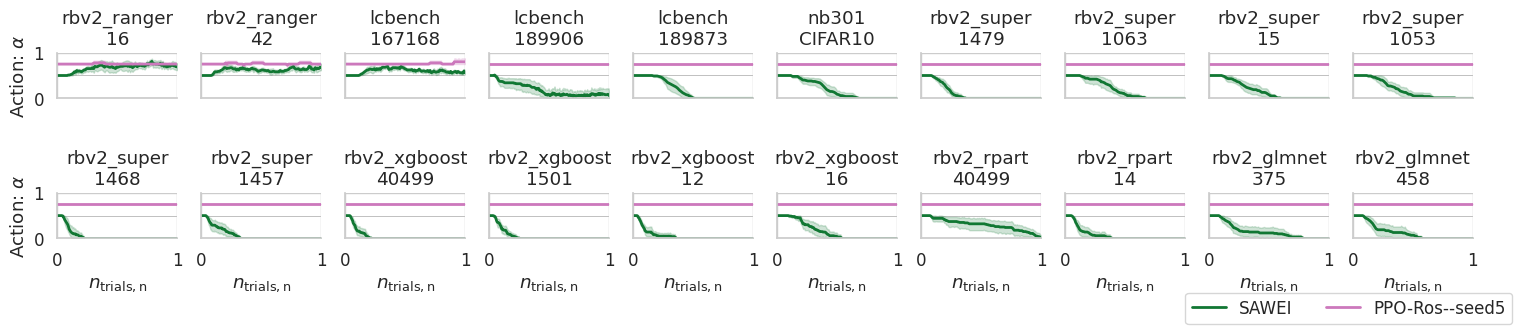

In [56]:

actions_to_plot = actions[actions["benchmark_id"].map(lambda x: x in {"YAHPO"})].copy()
def fix_yahpo_task_id(tid: str) -> str:
    return tid.replace("yahpo/so/", "").replace("/None", "").replace("/", "\n")
actions_to_plot["task_id"] = actions_to_plot["task_id"].map(fix_yahpo_task_id)

grid = sns.FacetGrid(data=actions_to_plot, col="task_id", col_wrap=10, height=1.5)

for i, (task_id, gdf) in enumerate(actions_to_plot.groupby("task_id")):
    if i != 19 and False:
        continue
    ax = grid.axes.flat[i]
    ax.axhline(0.5, linestyle="-", linewidth=0.7, color="gray", zorder=0, alpha=0.5)
    ax = sns.lineplot(
        data=gdf,
        x="n_trials_norm", y="action",
        # style="benchmark_id",
        hue="optimizer_id", palette=palette,
        linewidth=2,
        ax=ax
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0,1])
    ax.legend().remove()
ax.legend(bbox_to_anchor=(1.4,-1), ncols=10)
grid.set_xlabels("$n_\mathrm{trials,n}$")
grid.set_ylabels("Action: $\\alpha$")
grid.set_titles(col_template="{col_name}")
# grid.figure.tight_layout()
grid.figure.subplots_adjust(wspace=0.2)
savefig(grid.figure, "figures/results_icml/alpha_yahpo")
plt.show()

In [58]:
actions_to_plot.columns

Index(['action', 'action_type', 'n_trials', 'policy_id', 'seed', 'task_id',
       'optimizer_id', 'reward_id', 'action_space_id', 'observation_space_id',
       'objective_function', 'reward', 'ubr_smoothed_gradient', 'acq_value_PI',
       'acq_value_WEI_explore', 'previous_param', 'reference_performance_id',
       'action_values', 'benchmark_id', 'n_trials_norm'],
      dtype='object')

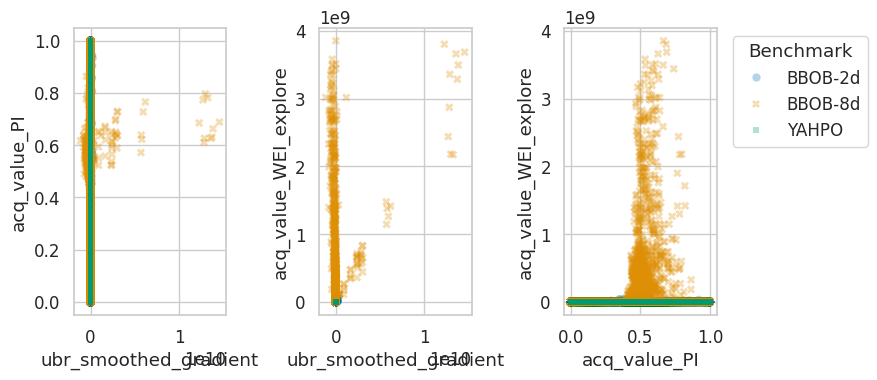

In [ ]:
from sklearn.decomposition import PCA
import itertools

actions_to_plot = actions[actions["optimizer_id"].map(lambda x: x in {"PPO-Ros--seed5"})].copy()
actions_to_plot = actions_to_plot[actions_to_plot["benchmark_id"].isin(["BBOB-2d", "BBOB-8d", "YAHPO"])]

def apply_pca_reduction(obs, obs_keys):
    X = obs[obs_keys].to_numpy()
    # X = X[~np.isnan(X).any(axis=1)]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    obs["X_pca"] = list(X_pca)
    expanded = obs["X_pca"].apply(pd.Series)
    expanded.columns = [f"x_{i},pca" for i in range(X_pca.shape[-1])]
    return obs.drop(columns="X_pca").join(expanded)

obs_keys = ["ubr_smoothed_gradient", "acq_value_PI", "acq_value_WEI_explore"]
# actions_to_plot = apply_pca_reduction(actions_to_plot, obs_keys)

# fig = plt.figure(figsize=(4,3))
# ax = fig.add_subplot(111)
# ax = sns.scatterplot(data=actions_to_plot, x="x_0,pca", y="x_1,pca", hue="benchmark_id", ax=ax, alpha=0.75, style="benchmark_id")
# ax.legend(title="Benchmark")
# savefig(fig, "figures/results_icml/statespace_bbob_vs_yahpo")
# plt.show()

combos = list(itertools.combinations(obs_keys, r=2))

fig = plt.figure(figsize=(9,3))
axes = fig.subplots(nrows=1, ncols=len(combos), sharex=False, sharey=False)
for i, combo in enumerate(combos):
    ax = axes[i]
    ax = sns.scatterplot(data=actions_to_plot, x=combo[0], y=combo[1], hue="benchmark_id", ax=ax, alpha=0.3, linewidth=0, style="benchmark_id")
    ax.legend().remove()
ax.legend(title="Benchmark", bbox_to_anchor=(1.05, 1))
fig.tight_layout()
savefig(fig, f"figures/results_icml/statespace_bbob_vs_yahpo_{'_'.join(obs_keys)}")
plt.show()

['PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SMAC3-BlackBoxFacade_Ibbob2d_3seeds--seed3']
BBOB-2d


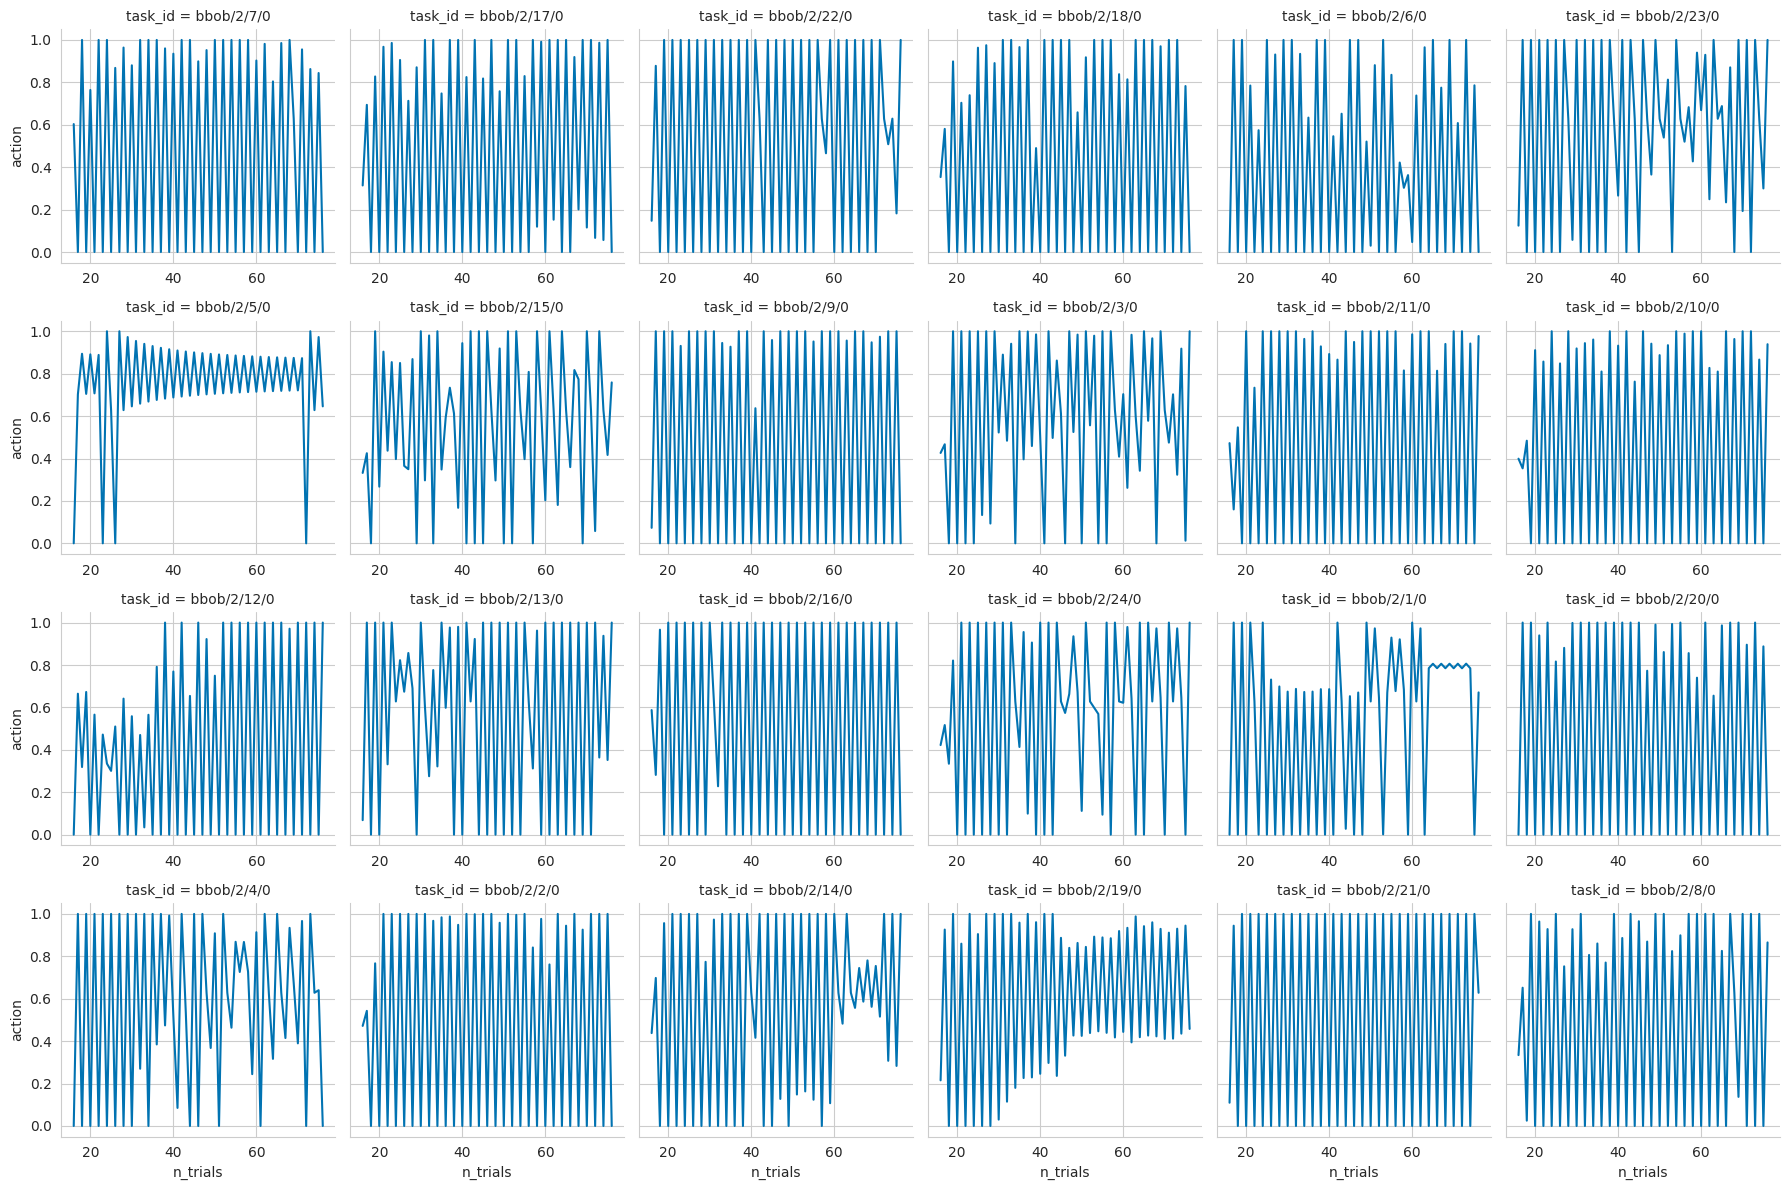

BBOB-8d


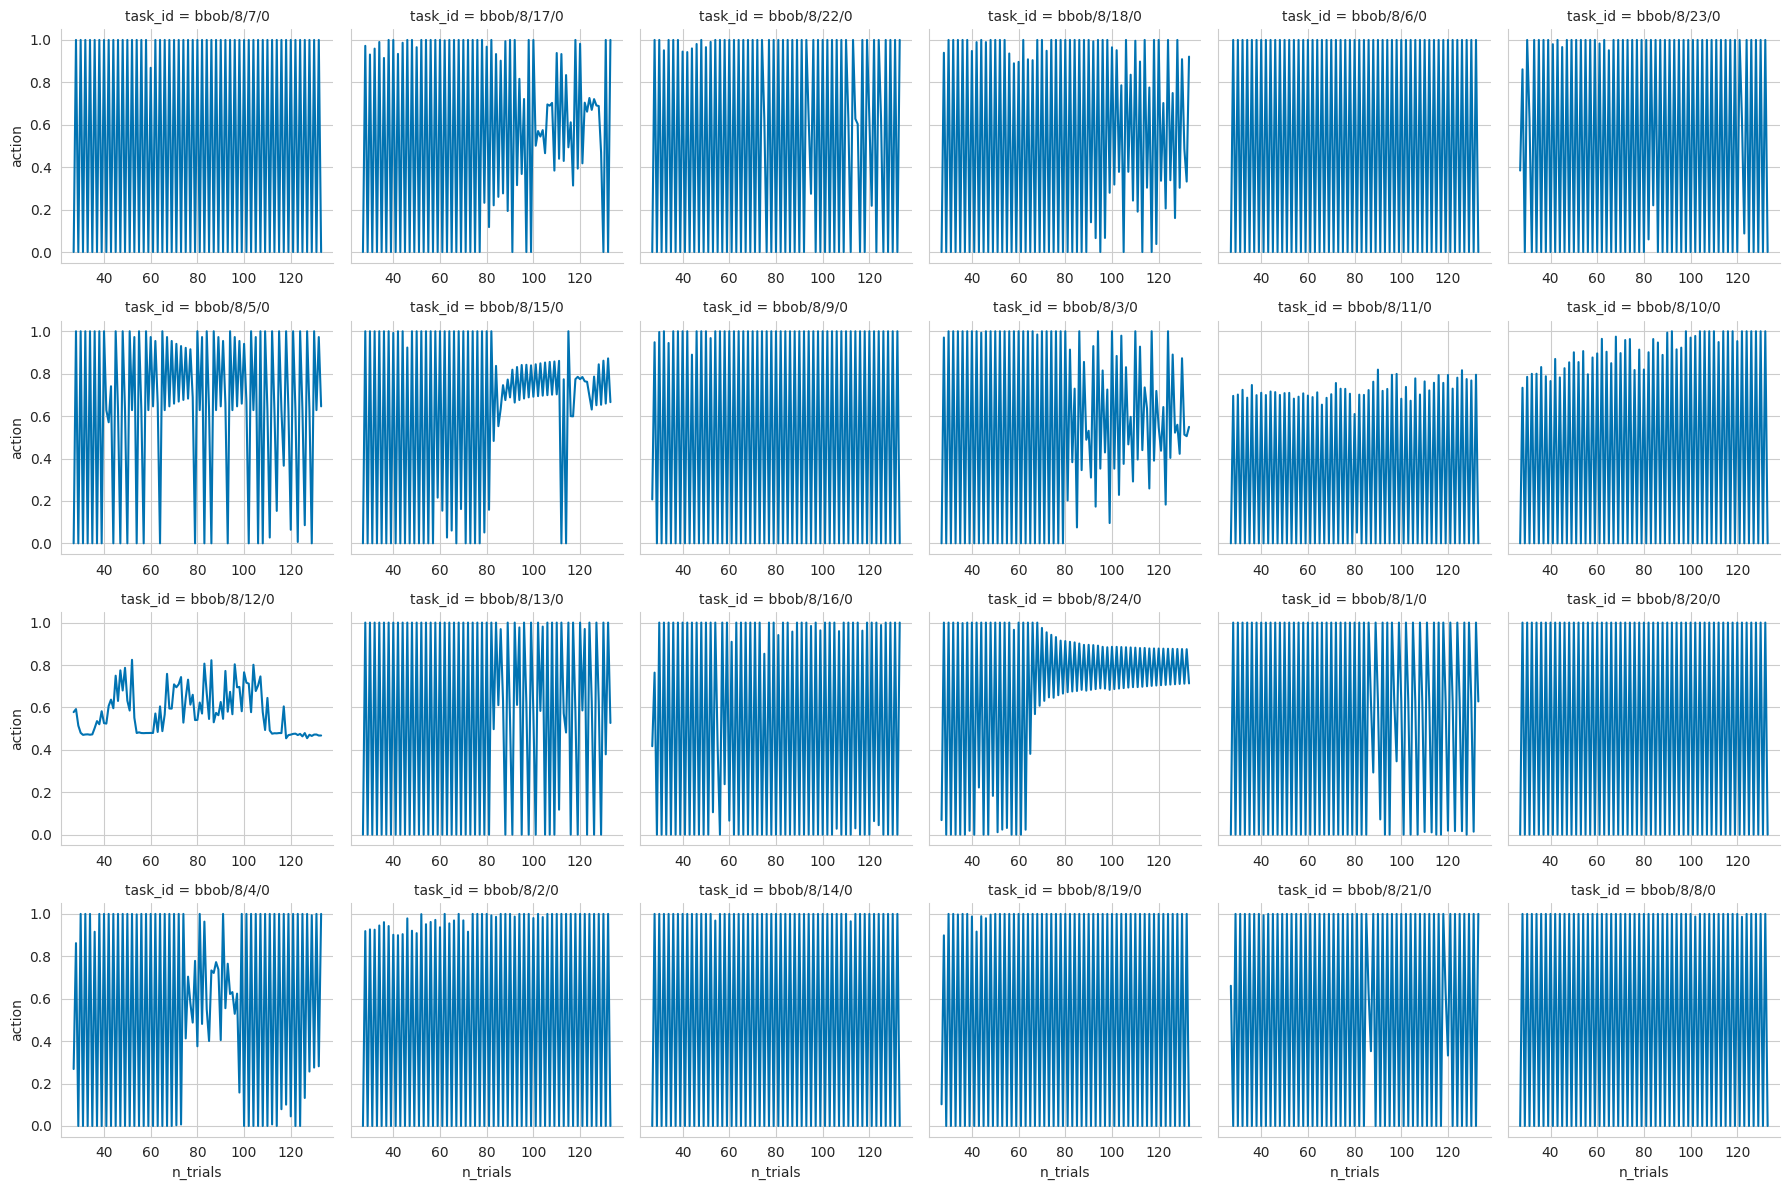

OptBench


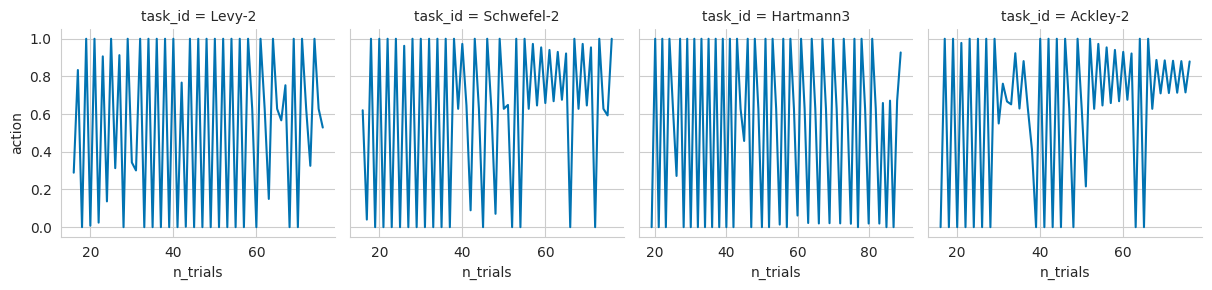

YAHPO


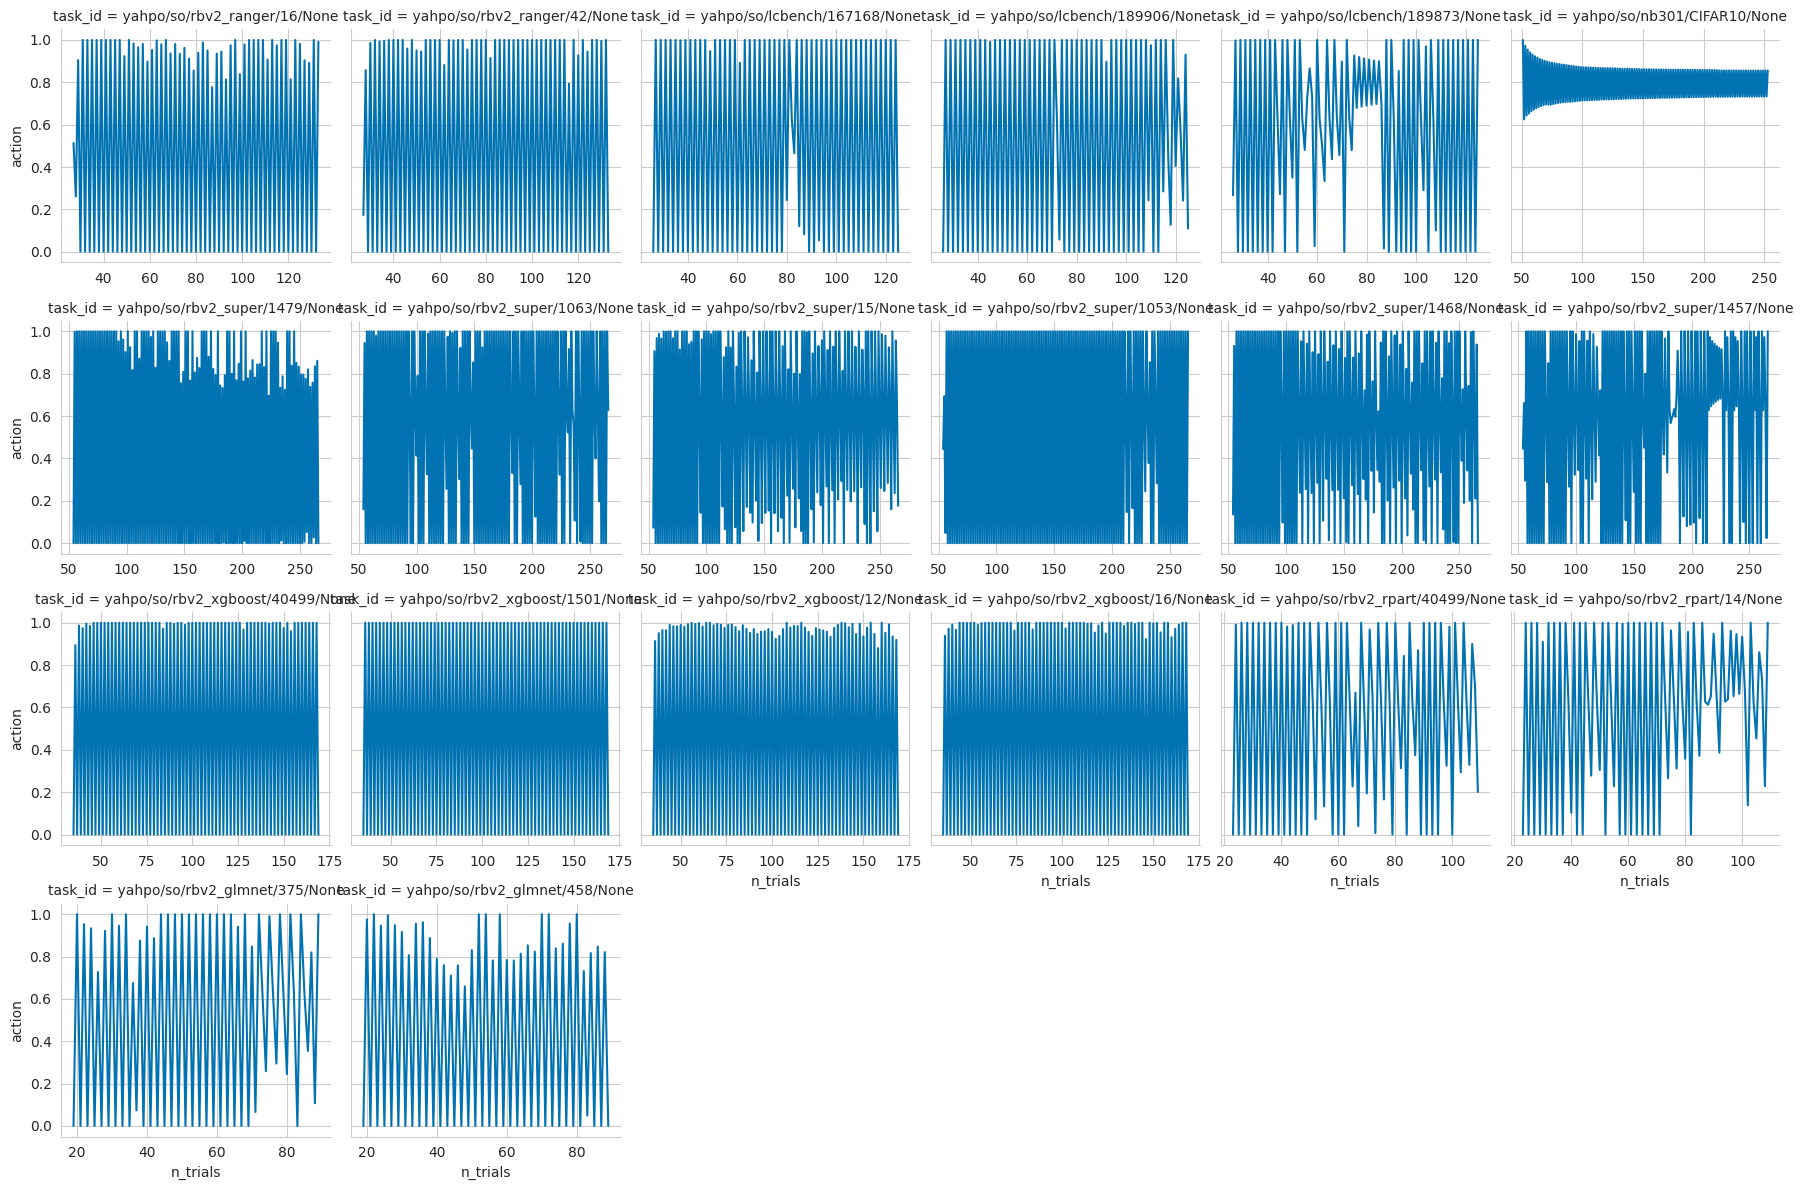

nasengb


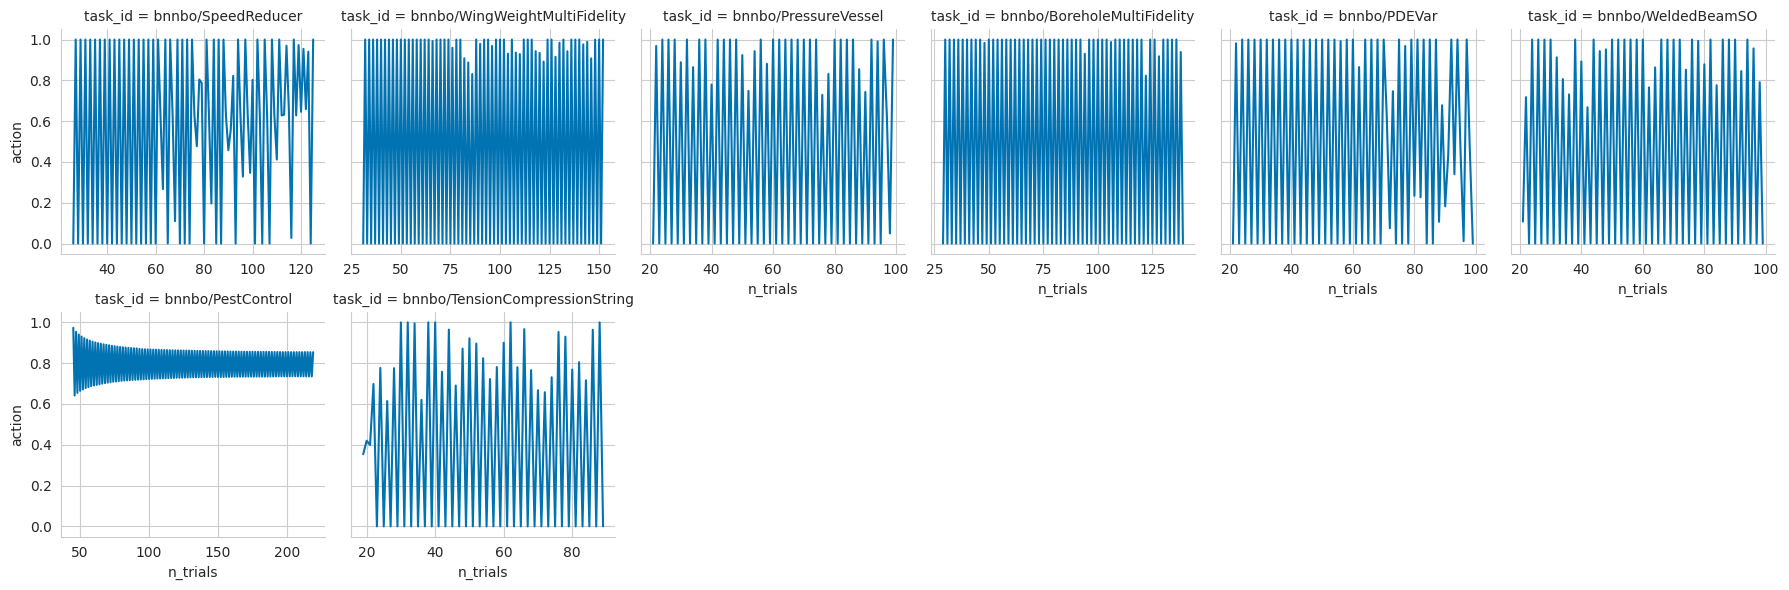

In [43]:

import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn, get_color_palette, get_marker_palette
from carps.analysis.gather_data import get_interpolated_performance_df
import pandas as pd

def get_benchmark_id(task_id: str) -> str:
    if task_id.startswith("bbob/2"):
        return "BBOB-2d"
    if task_id.startswith("bbob/8"):
        return "BBOB-8d"
    if task_id.startswith("yahpo"):
        return "YAHPO"
    if task_id.startswith("bnnbo"):
        return "nasengb"
    else:
        return "OptBench"
    raise ValueError(f"unkown task {task_id}")

setup_seaborn()
%matplotlib inline

actions = pd.read_parquet("actions.parquet")
actions["benchmark_id"] = actions["task_id"].map(get_benchmark_id)

policies_to_plot = ["PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SMAC3-BlackBoxFacade_Ibbob2d_3seeds--seed3"]
print(actions["policy_id"].unique())
actions_to_plot = actions[actions["policy_id"].isin(policies_to_plot)]
actions_to_plot = actions_to_plot[actions_to_plot["seed"] == 1]

for benchmark_id, gdf in actions_to_plot.groupby("benchmark_id"):
    print(benchmark_id)
    grid = sns.FacetGrid(data=gdf, col="task_id", col_wrap=6, sharex=False, sharey=True)
    grid.map_dataframe(sns.lineplot,
        # data=group[(group["seed"]==2) & (group["optimizer_id"].str.contains("fid8_3seeds--seed1"))],
        x="n_trials", y="action",# hue="task_id", palette=palette,
        hue="seed", palette="colorblind"
        # style="task_id", dashes=False, markers=marker_palette, markevery=10,
        # style="seed"
        )
    plt.show()


In [30]:
actions["benchmark_id"].unique()

array(['nasengb', 'BBOB-2d', 'BBOB-8d', 'YAHPO'], dtype=object)

/tmp/ipykernel_773778/3410275489.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["run_id"] = df_plot.apply(get_run_id, axis="columns")
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/scratch/hpc-prf-intexml/cbenjamins/repos/dacb

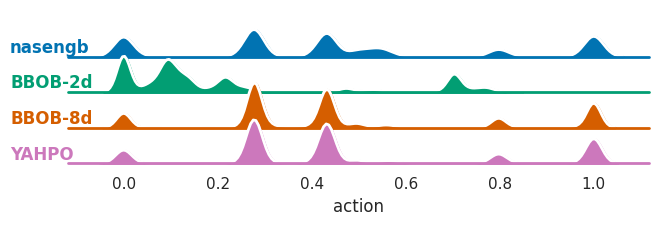

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn, get_color_palette, get_marker_palette, savefig
from carps.analysis.gather_data import get_interpolated_performance_df
import pandas as pd

setup_seaborn()
%matplotlib inline

def get_run_id(row: pd.Series) -> str:
    task_id = row["task_id"]
    policy_id = row["policy_id"]
    seed = row["seed"]
    return f"{task_id}{policy_id}{seed}"

df_plot = actions[actions["policy_id"] == "PPO--eplen | bbob_2d"]
df_plot["run_id"] = df_plot.apply(get_run_id, axis="columns")
policies = list(df_plot["policy_id"].unique())
palette = get_color_palette(optimizers=policies)
palette["DefaultPolicy"] = "black"
marker_palette = get_marker_palette(optimizers=policies)
# perf = get_interpolated_performance_df(logs=df_plot, n_points=20, interpolation_columns=["action"], group_keys=["task_id", "policy_id", "seed", "benchmark_id", "run_id"])

# sns.histplot(data=df_plot, x="action", hue="benchmark_id", stat="density")

df = df_plot
variable = "action"

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
pal = sns.color_palette("colorblind6")
g = sns.FacetGrid(df, row="benchmark_id", hue="benchmark_id", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, variable,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, variable, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, variable)
g.set_ylabels("Action (WEI-$\\alpha$")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

savefig(fig=g.figure, filename="figures/results/action_ppo_eplen_bbob2d")



/tmp/ipykernel_773778/1118691154.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["run_id"] = df_plot.apply(get_run_id, axis="columns")
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/scratch/hpc-prf-intexml/cbenjamins/repos/dacb

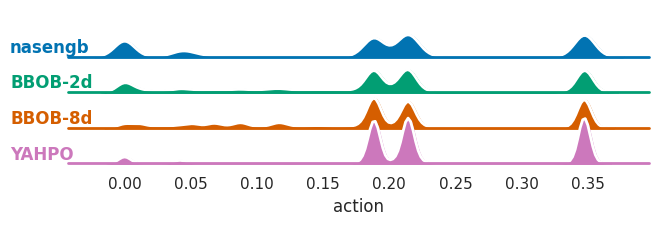

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn, get_color_palette, get_marker_palette, savefig
from carps.analysis.gather_data import get_interpolated_performance_df
import pandas as pd

setup_seaborn()
%matplotlib inline

def get_run_id(row: pd.Series) -> str:
    task_id = row["task_id"]
    policy_id = row["policy_id"]
    seed = row["seed"]
    return f"{task_id}{policy_id}{seed}"

df_plot = actions[actions["policy_id"] == "PPO--symlogregret | bbob_2d"]
df_plot["run_id"] = df_plot.apply(get_run_id, axis="columns")
policies = list(df_plot["policy_id"].unique())
palette = get_color_palette(optimizers=policies)
palette["DefaultPolicy"] = "black"
marker_palette = get_marker_palette(optimizers=policies)
# perf = get_interpolated_performance_df(logs=df_plot, n_points=20, interpolation_columns=["action"], group_keys=["task_id", "policy_id", "seed", "benchmark_id", "run_id"])

# sns.histplot(data=df_plot, x="action", hue="benchmark_id", stat="density")

df = df_plot
variable = "action"

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
pal = sns.color_palette("colorblind6")
g = sns.FacetGrid(df, row="benchmark_id", hue="benchmark_id", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, variable,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, variable, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, variable)
g.set_ylabels("Action (WEI-$\\alpha$")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

savefig(fig=g.figure, filename="figures/results/action_ppo_eplen_bbob2d_right")



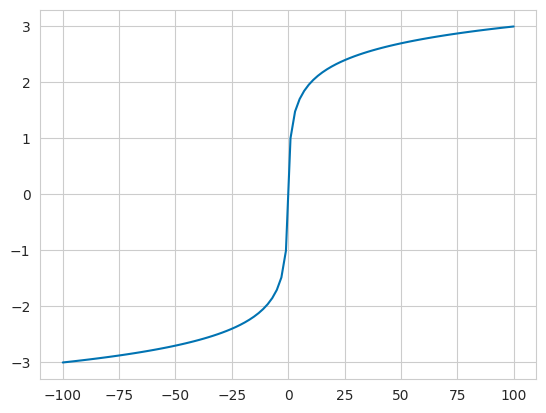

In [5]:
def symlog(x, linthresh=1.0, base=10):
    x = np.asarray(x)
    sign = np.sign(x)
    abs_x = np.abs(x)

    return sign * np.where(
        abs_x <= linthresh,
        abs_x / linthresh,
        1 + np.log(abs_x / linthresh) / np.log(base)
    )

X = np.linspace(-100, 100, 100)
Y = symlog(X)
plt.plot(X, Y)